# ROC curves, AUC (area under the curve) and MCC (Matthews' correlation coefficient)

In this notebook, we illustrate how to:

1. draw the ROC curve
2. calculate the AUC (area under the curve)
3. claculate the MCC (Matthew's correlation coefficient)

## Loading libraries

First of all, we load some necessary general libraries:

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Get the data

We are using results from a mock binary classification problem.
This was based on the [breast cancer Wisconsin dataset](https://github.com/scikit-learn/scikit-learn/blob/6e9039160f0dfc3153643143af4cfdca941d2045/sklearn/datasets/data/breast_cancer.csv) from the Python library `sklearn`.

In this dataset, the objective is to diagnose the status of breast cancer:

- `0`: malignant cancer
- `1`: benign cancer

The dataset contains **569 examples**:

- 212 malignant
- 357 benign

And the prediction (classification) is based on 30 numeric features related to the cancer lesions (size, shape etc.: full description can be found [here](https://scikit-learn.org/1.5/datasets/toy_dataset.html#breast-cancer-dataset)).

Actually, in this example we used a random subset of the 30 features, by selecting 8 features: in this way, the problem was harder, and we obtained more classification errors, which is instrumental to the illustration of different metrics to measure model performance.

The dataset is imbalanced: the ratio between the two classes is not 1, but 0.6.
Again, this is instrumental in showing the relative advantage of using different performance metrics rather than just looking at the error rate / overall accuracy.

In [41]:
DATASET_URL = 'https://raw.githubusercontent.com/ne1s0n/bioinformateachers/refs/heads/main/dlb/data/predictions.csv'

The dataframe contains:

- the **original test observation** (the "truth": malignant or benign)
- the **predicted class** (binary)
- the **two probabilities**: of being '0' (malignant) or '1' (benign)

In [42]:
bc_data = pd.read_csv(DATASET_URL)
bc_data.head()

,y_test,y_pred,prob_0,prob1
0,1.0,1.0,0.013791,0.986209
1,1.0,1.0,0.022589,0.977411
2,1.0,1.0,0.340036,0.659964
3,0.0,0.0,0.999988,0.000012
4,1.0,1.0,0.029998,0.970002


The test dataset was generated by taking a 20% random subset of the data: **114 test examples**.

In [43]:
len(bc_data)

114

---

Let's get a look at the original **confusion matrix**: first we get the two vectors of predictions and observations, and then construct the matrix of correct predictions (diagonal) and errors (off diagonal).

In [44]:
y_test = np.array(bc_data['y_test'])
y_pred = np.array(bc_data['y_pred'])

In [45]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[34,  7],
       [ 4, 69]])

---

The next bit will be to bring the **probabilities of prediction** in the game, not just the predicted classes.

Keep in mind that the predicted classes have been obtained based on the **0.5 threshold**: each test example is attributed to the class whose probability is larger than 50%.

In [55]:
y_probs = np.array(bc_data[bc_data.columns[2:4]])
print(y_probs[0:5,:])

[[1.37907635e-02 9.86209236e-01]
 [2.25887425e-02 9.77411258e-01]
 [3.40035689e-01 6.59964311e-01]
 [9.99988475e-01 1.15251572e-05]
 [2.99984697e-02 9.70001530e-01]]


---

### ROC curves

In [61]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [48]:
y_probs[:,1].shape

(114,)

In [49]:
fpr, tpr, _ = roc_curve(y_test, y_probs[:,1])

In [50]:
roc_auc = auc(fpr, tpr)

In [51]:
roc_auc

0.9555629802873371

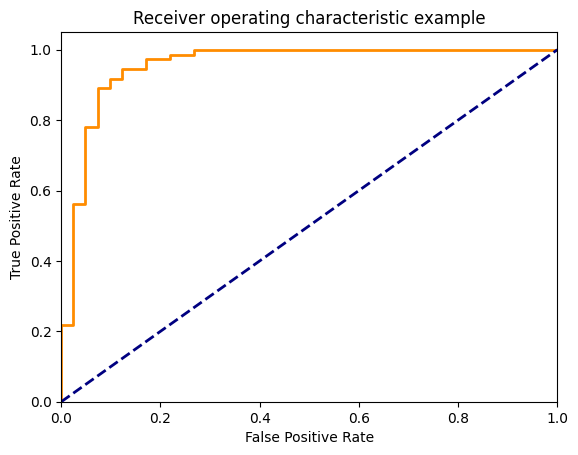

In [60]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    #label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
#plt.legend(loc="lower right")
plt.show()

[TODO]